## Confronto modelli KNN su dataset Empty, Crowded e Hybrid
### 1. Import delle librerie e caricamento dei dati

In [60]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Importing dataset
file_path = "../../data/processed/wifi_fingerprinting_dataset_binarized.csv"

df = pd.read_csv(file_path, sep=',')

df_empty = df[df["Situazione"] == "Empty"].drop(columns=["Situazione"])
df_crowded = df[df["Situazione"] == "Crowded"].drop(columns=["Situazione"])
df_hybrid = df.drop(columns=["Situazione"])

### 2. Creazione dei modelli

In [61]:
# Split the data into training, validation and test sets
def split_data(df):
    X = df.drop(columns=["Aula"])
    y = df["Aula"]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train_empty, X_val_empty, X_test_empty, y_train_empty, y_val_empty, y_test_empty = split_data(df_empty)
X_train_crowded, X_val_crowded, X_test_crowded, y_train_crowded, y_val_crowded, y_test_crowded = split_data(df_crowded)
X_train_hybrid, X_val_hybrid, X_test_hybrid, y_train_hybrid, y_val_hybrid, y_test_hybrid = split_data(df_hybrid)

# Display the number of samples in each split for all datasets
def print_split_info(name, X_train, X_val, X_test):
    print(f"\n{name} dataset:")
    print(f"  Train set:      {X_train.shape[0]} samples")
    print(f"  Validation set: {X_val.shape[0]} samples")
    print(f"  Test set:       {X_test.shape[0]} samples")

print_split_info("Empty", X_train_empty, X_val_empty, X_test_empty)
print_split_info("Crowded", X_train_crowded, X_val_crowded, X_test_crowded)
print_split_info("Hybrid", X_train_hybrid, X_val_hybrid, X_test_hybrid)


Empty dataset:
  Train set:      338 samples
  Validation set: 73 samples
  Test set:       73 samples

Crowded dataset:
  Train set:      349 samples
  Validation set: 75 samples
  Test set:       75 samples

Hybrid dataset:
  Train set:      688 samples
  Validation set: 147 samples
  Test set:       148 samples


### 3. Addestramento dei modelli

In [62]:
# Find the best k value for each dataset (with validation set)
def find_best_k(X_train, y_train, X_val, y_val):
    k_values = range(1, 21)
    best_k = None
    best_acc = 0
    accuracies = {}

    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        acc = accuracy_score(y_val, model.predict(X_val))
        accuracies[k] = acc
        if acc > best_acc:
            best_k = k
            best_acc = acc

    return best_k, best_acc, accuracies

best_k_empty, acc_empty, accs_empty = find_best_k(X_train_empty, y_train_empty, X_val_empty, y_val_empty)
best_k_crowded, acc_crowded, accs_crowded = find_best_k(X_train_crowded, y_train_crowded, X_val_crowded, y_val_crowded)
best_k_hybrid, acc_hybrid, accs_hybrid = find_best_k(X_train_hybrid, y_train_hybrid, X_val_hybrid, y_val_hybrid)

print(f"Empty -> Best k: {best_k_empty}, Validation accuracy: {acc_empty:.4f}")
print(f"Crowded -> Best k: {best_k_crowded}, Validation accuracy: {acc_crowded:.4f}")
print(f"Hybrid -> Best k: {best_k_hybrid}, Validation accuracy: {acc_hybrid:.4f}")

Empty -> Best k: 1, Validation accuracy: 0.9452
Crowded -> Best k: 2, Validation accuracy: 0.8933
Hybrid -> Best k: 3, Validation accuracy: 0.9388


### 4. Plot accuracies

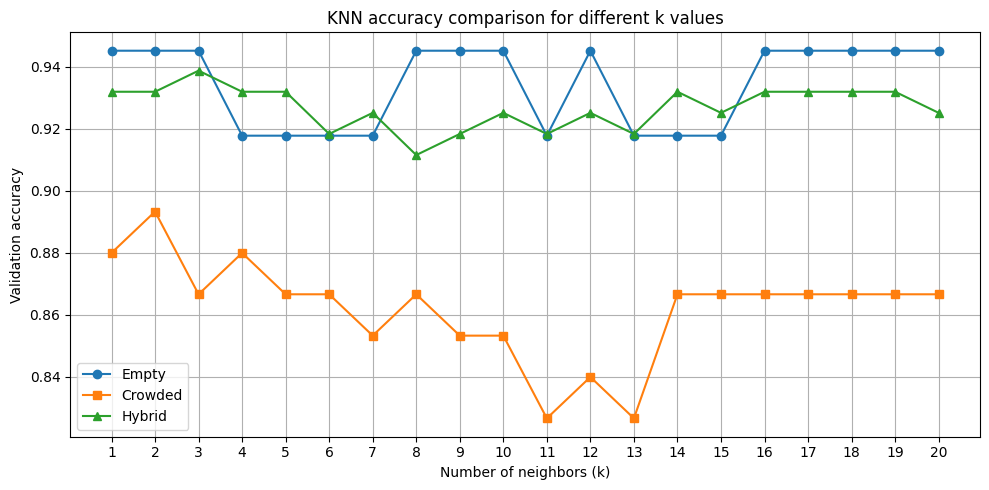

In [63]:
# Accuracy comparison for different k values
k_values = list(accs_empty.keys())
plt.figure(figsize=(10, 5))
plt.plot(k_values, accs_empty.values(), marker='o', label='Empty')
plt.plot(k_values, accs_crowded.values(), marker='s', label='Crowded')
plt.plot(k_values, accs_hybrid.values(), marker='^', label='Hybrid')
plt.xlabel('Number of neighbors (k)')
plt.ylabel('Validation accuracy')
plt.title('KNN accuracy comparison for different k values')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 5. Risultati


Summary of Test Set Results:


,Model,k,Accuracy,Precision,Recall,F1-score
0,Empty,1,0.959,0.961,0.959,0.959
1,Crowded,2,0.880,0.879,0.880,0.876
2,Hybrid,3,0.939,0.945,0.939,0.940



Confusion Matrices:


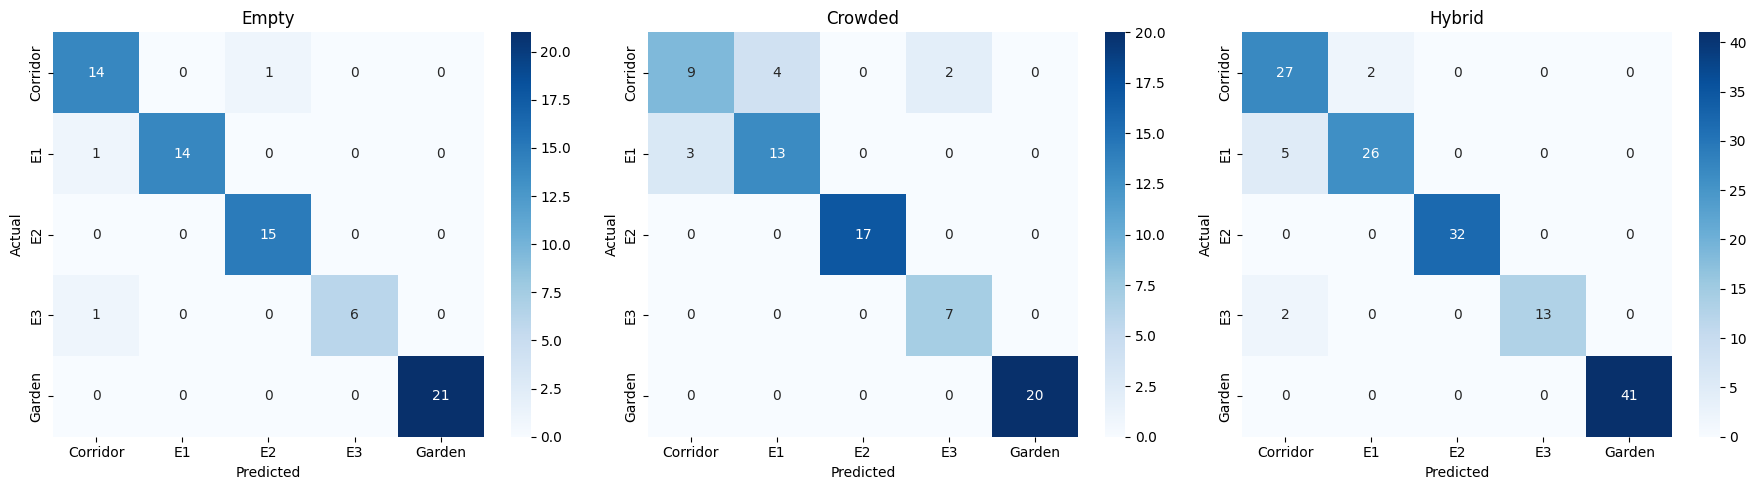

In [64]:
def evaluate_on_test_summary(X_train, y_train, X_test, y_test, k, label):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    return {
        "Model": label,
        "k": k,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    }

# Collect results
results = []
results.append(evaluate_on_test_summary(X_train_empty, y_train_empty, X_test_empty, y_test_empty, best_k_empty, "Empty"))
results.append(evaluate_on_test_summary(X_train_crowded, y_train_crowded, X_test_crowded, y_test_crowded, best_k_crowded, "Crowded"))
results.append(evaluate_on_test_summary(X_train_hybrid, y_train_hybrid, X_test_hybrid, y_test_hybrid, best_k_hybrid, "Hybrid"))

# Display as DataFrame
results_df = pd.DataFrame(results)
print("\nSummary of Test Set Results:")
display(results_df.round(3))

def plot_conf_matrices():
    datasets = [
        ("Empty", X_train_empty, y_train_empty, X_test_empty, y_test_empty, best_k_empty),
        ("Crowded", X_train_crowded, y_train_crowded, X_test_crowded, y_test_crowded, best_k_crowded),
        ("Hybrid", X_train_hybrid, y_train_hybrid, X_test_hybrid, y_test_hybrid, best_k_hybrid),
    ]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for ax, (label, X_train, y_train, X_test, y_test, k) in zip(axes, datasets):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), ax=ax)
        ax.set_title(f"{label}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

print("\nConfusion Matrices:")
plot_conf_matrices()